In [1]:
from fewshot.data.tiered_imagenet import TieredImageNetDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models

from torch.utils.data import DataLoader

import torch_scatter
import numpy as np

#### Sanity check plot

In [15]:
dataset = TieredImageNetDataset(folder='./tiered-imagenet',
                                split='train',
                                label_ratio=1,
                                mode_ratio=1,
                                num_distractor=0,
                                num_unlabel=0,
                                nway=2, # groups per category
                                cat_way=5, # categories
                                nshot=3)  # examples per group

Created mapping from category to their synset codes with 20 entries.
num unlabel 0
num test 5
num distractor 0
Read cached labels from ./tiered-imagenet/train_labels.pkl
Found 351 synsets belonging to a total of 20 categories for split train.
Read cached images from ./tiered-imagenet/train_images.npz
self._images.shape (448695, 84, 84, 3)


5-way (class=category) with 2 groups per category and 3 examples per group. Each row corresponds to a different class/category. The first 3 images per row correspond to one group within the category, the last 3 to another.

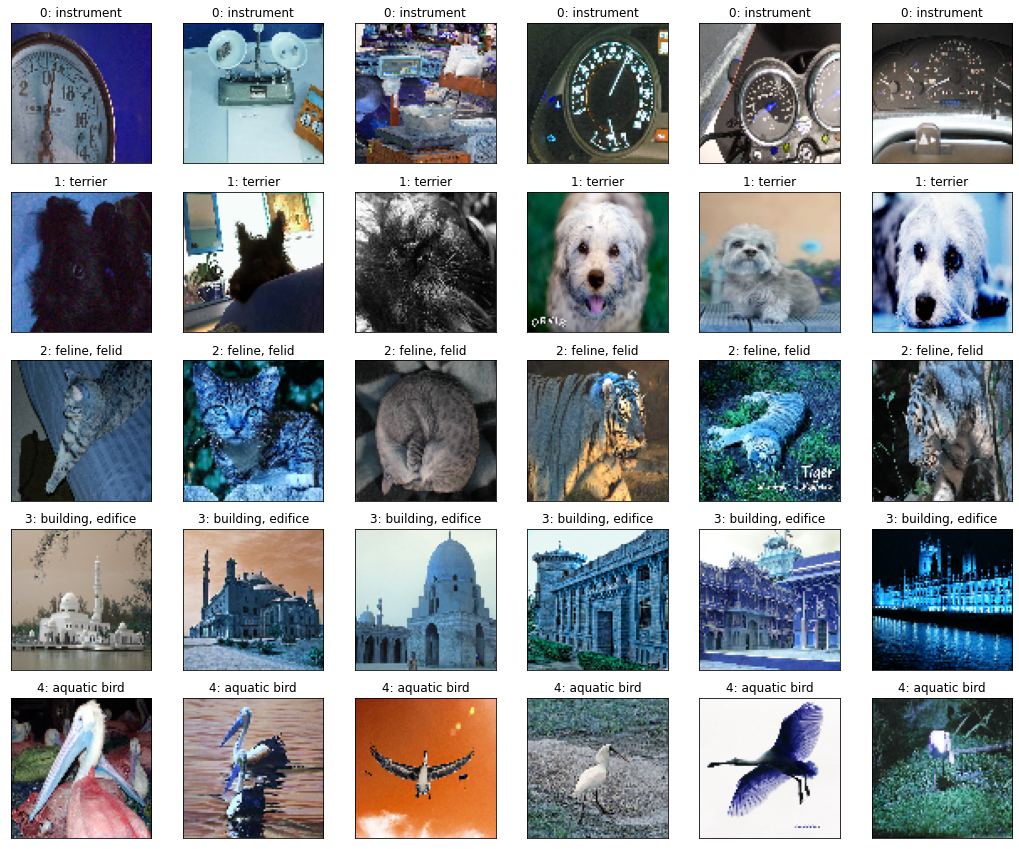

In [16]:
episode = dataset.next_episode(within_category=True)
plt.figure(figsize=(18, 15))
for i in range(episode.x_train.shape[0]):
    plt.subplot(5, 6, i+1)
    plt.imshow(episode.x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('{}: {}'.format(episode.y_train_str[i][1], dataset._label_general_str[episode.y_train_str[i][0]]))

#### Model

In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [18]:
def hot_attn(Q,K,V,temp):
    return torch.softmax(Q@K.T/temp,-1)@V

In [213]:
def cos_attn(Q,K,V):
    cos = (Q @ K.T) / torch.outer(torch.norm(Q,dim=1),torch.norm(K,dim=1))
    return torch.softmax(cos,-1) @ V

In [19]:
def one_hot(y_int):
    y_onehot = torch.zeros(y_int.size(0),y_int.max().item()+1)
    y_onehot.scatter_(1, y_int.unsqueeze(-1), 1)
    return y_onehot

In [20]:
def mean_abs_dev(X):
    return (X-X.mean(0)).abs().mean(0)

In [21]:
def classify_proto(train, test, train_labels, **kwargs):
    proto = torch_scatter.scatter_mean(train, train_labels.type(torch.int64), dim=0)

    # Compute predictions
    logits = euclidean_metric(test, proto)
    # predictions = torch.softmax(logits, axis=-1)

    return logits

In [22]:
def euclidean_metric(a, b):
    n = a.shape[0]
    m = b.shape[0]
    a = a.unsqueeze(1).expand(n, m, -1)
    b = b.unsqueeze(0).expand(n, m, -1)
    logits = -((a - b)**2).sum(dim=2)
    return logits

In [214]:
class feature_selector(torch.nn.Module):
    def __init__(self, iterations, temperature, mad=False):
        super(feature_selector,self).__init__()
        self.iterations = iterations
        self.temperature = temperature
        self.mad = mad
        
    def forward(self,X,y):
        
        S = (X-X.mean(0))/(X.std(0) + 0.1)
        
        for k in y.unique():
            for _ in range(self.iterations):
                S[y==k] = cos_attn(S[y==k],S[y==k],S[y==k])
#                 S[y==k] = hot_attn(S[y==k],S[y==k],S[y==k],self.temperature)
        
        if self.mad:
            return mean_abs_dev(S)
        else:
            return S.std(0)

In [248]:
dataset = TieredImageNetDataset(folder='./tiered-imagenet',
                                split='test',
                                label_ratio=1,
                                mode_ratio=1,
                                num_distractor=0,
                                num_unlabel=0,
                                nway=10, # groups per category
                                cat_way=10, # categories
                                nshot=10,  # examples per group
                                num_test=10) # queries per group

Created mapping from category to their synset codes with 8 entries.
num unlabel 0
num test 10
num distractor 0
Read cached labels from ./tiered-imagenet/test_labels.pkl
Found 160 synsets belonging to a total of 8 categories for split test.
Read cached images from ./tiered-imagenet/test_images.npz
self._images.shape (206209, 84, 84, 3)


In [249]:
resnet18 = models.resnet18(pretrained=True)
# replace the final layer with an identity rather than the class projection
resnet18.fc = Identity()
resnet18.eval()
# outputs are now the 512 features from the penultimate layer, e.g. for rand
resnet18(torch.rand(1,3,224,224)).size()

torch.Size([1, 512])

In [250]:
nb_episodes = 500
its, temp = 5, 64
fs = feature_selector(iterations=its, temperature=temp)
with torch.no_grad():
    mn_score = []
    pn_score = []
    fs_score = []
    tk_score = []
    for i in range(nb_episodes):
        episode = dataset.next_episode(within_category=True)
        x_spt = torch.tensor(np.transpose(episode.x_train, (0, 3, 1, 2)), dtype=torch.float32)
        x_qry = torch.tensor(np.transpose(episode.x_test, (0, 3, 1, 2)), dtype=torch.float32)
        y_spt = torch.tensor(episode.y_train_str[:, 1])
        y_qry = torch.tensor(episode.y_test_str[:, 1])

        X_S = resnet18(x_spt)
        X_Q = resnet18(x_qry)
        
        # matching nets
        mn_cos = (X_Q @ X_S.T) / torch.outer(torch.norm(X_Q,dim=1),torch.norm(X_S,dim=1))
        mn_pred = (torch.softmax(mn_cos,-1) @ one_hot(y_spt)).argmax(-1)
        mn_correct = (y_qry == mn_pred).sum().item()
        mn_score.append(1.*mn_correct/y_qry.size(-1))
        
        # proto nets
        pn_correct = (y_qry == classify_proto(X_S,X_Q,y_spt).argmax(-1)).sum().item()
        pn_score.append(1.*pn_correct/y_qry.size(-1))
        
        # feature selection
        rescale = (fs(X_S,y_spt))**0.5

        rXs = X_S * rescale
        rXq = X_Q * rescale

        fs_cos = (rXq @ rXs.T) / torch.outer(torch.norm(rXq,dim=1),torch.norm(rXs,dim=1))
        fs_pred = (torch.softmax(fs_cos,-1) @ one_hot(y_spt)).argmax(-1)
        fs_correct = (y_qry == fs_pred).sum().item()
        fs_score.append(1.*fs_correct/y_qry.size(-1))
        
        if (i+1)%10 == 0:
            print(i+1)
        
mn_score, pn_score, fs_score = np.array(mn_score), np.array(pn_score), np.array(fs_score)
mn_mean, mn_stderr = 100*mn_score.mean(), 100*mn_score.std()/np.sqrt(nb_episodes)
pn_mean, pn_stderr = 100*pn_score.mean(), 100*pn_score.std()/np.sqrt(nb_episodes)
fs_mean, fs_stderr = 100*fs_score.mean(), 100*fs_score.std()/np.sqrt(nb_episodes)
print(f'MN {mn_mean:.2f}±{mn_stderr:.2f}')
print(f'PN {pn_mean:.2f}±{pn_stderr:.2f}')
print(f'FS {fs_mean:.2f}±{fs_stderr:.2f}')
print(f'FS v MN: FS {(fs_score > mn_score).sum()}, MN {(fs_score < mn_score).sum()}, draw {(fs_score == mn_score).sum()}')
print(f'FS v PN: FS {(fs_score > pn_score).sum()}, PN {(fs_score < pn_score).sum()}, draw {(fs_score == pn_score).sum()}')
print(f'MN v PN: MN {(mn_score > pn_score).sum()}, PN {(mn_score < pn_score).sum()}, draw {(mn_score == pn_score).sum()}')
print(f'Wilcoxon(FS,MN) {wilcoxon(fs_score, mn_score)}')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
MN 54.20±0.10
PN 50.26±0.09
FS 54.39±0.10
FS v MN: FS 281, MN 184, draw 35
FS v PN: FS 493, PN 5, draw 2
MN v PN: MN 488, PN 10, draw 2
Wilcoxon(FS,MN) WilcoxonResult(statistic=37866.5, pvalue=1.8236307425732938e-08)


In [237]:
wilcoxon(fs_score, mn_score)

WilcoxonResult(statistic=34645.0, pvalue=0.21192267944411636)